EfficientNetB0 model to implement for the FeelBeat Project

In [ ]:
!pip install Keras-Applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
model = ResNet50V2(weights='imagenet')
print(len(model.layers))

102869336/102869336 [==============================] - 1s 0us/step
192


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

In [ ]:

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from sklearn.metrics import *
from tensorflow.keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage.io
from keras.applications.nasnet import NASNetLarge
from skimage.transform import rescale, resize
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M
from tensorflow.keras.optimizers import Adam

import pydot


In [ ]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

Resize_pixelsize = 96
FROZEN_LAYER_NUM = 450

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! rm -rf train; mkdir train
! unzip -q '/content/drive/MyDrive/FeelBeat/Datasets/train.zip' -d train
! unzip -q '/content/drive/MyDrive/FeelBeat/Datasets/ck_train.zip' -d train
! unzip -q '/content/drive/MyDrive/FeelBeat/Datasets/ck+_train.zip' -d train
! unzip -q '/content/drive/MyDrive/FeelBeat/Datasets/train_jaffe.zip' -d train










In [ ]:
! rm -rf dev; mkdir dev
! unzip -q '/content/drive/MyDrive/FeelBeat/Datasets/test-public.zip' -d dev
! rm -rf test; mkdir test
! unzip -q '/content/drive/MyDrive/FeelBeat/Datasets/test-private.zip' -d test


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug =='train':
       datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
      datagen = ImageDataGenerator(rescale = 1./255)


    return datagen.flow_from_directory(
            dataset,
            target_size=(96, 96),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [ ]:
train_generator = get_datagen('/content/train',True)
dev_generator = get_datagen('/content/dev')
test_generator =get_datagen('/content/test')

Found 30533 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
# Load the EfficientB) model
efficientnetb2_notop = EfficientNetV2M(include_top=False, weights='imagenet', input_shape=(Resize_pixelsize, Resize_pixelsize, 3))

# Get the output from the last layer
last_layer = efficientnetb2_notop.output
x = Flatten(name='flatten')(last_layer)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(4096, activation='swish', name='fc6')(x)
x = Dropout(DROPOUT_RATE)(x)
x = Dense(1024, activation='swish', name='fc7')(x)
x = Dropout(DROPOUT_RATE)(x)


# Add a new classifier layer
out = Dense(7, activation='softmax', name='classifier')(x)
# Create the model
model = Model(inputs=efficientnetb2_notop.input, outputs=out)


# List all the indices of layers that are batch normalization layers
batch_norm_indices = [
    i for i, layer in enumerate(efficientnetb2_notop.layers)
    if 'BatchNormalization' in layer.__class__.__name__
]
print(batch_norm_indices)

for i in range(FROZEN_LAYER_NUM):
    if i not in batch_norm_indices:
        efficientnetb2_notop.layers[i].trainable = False



initial_learning_rate_optim = ADAM_LEARNING_RATE

learning_rate_schedule_optim = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate_optim,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

optim = keras.optimizers.Adam(learning_rate=learning_rate_schedule_optim, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    min_delta=0,
    patience=20,
    restore_best_weights=True,
    verbose=2,
)

rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=20, min_lr=0.00001, verbose=1)
callbacks_list = [rlrop,early_stop_callback]


model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['accuracy'])
#model.summary()

214201816/214201816 [==============================] - 1s 0us/step
[3, 6, 10, 15, 20, 23, 25, 28, 32, 35, 39, 42, 46, 49, 53, 56, 58, 61, 65, 68, 72, 75, 79, 82, 86, 89, 97, 99, 102, 110, 114, 117, 125, 129, 132, 140, 144, 147, 155, 159, 162, 170, 174, 177, 185, 189, 192, 200, 202, 205, 213, 217, 220, 228, 232, 235, 243, 247, 250, 258, 262, 265, 273, 277, 280, 288, 292, 295, 303, 307, 310, 318, 322, 325, 333, 337, 340, 348, 352, 355, 363, 367, 370, 378, 382, 385, 393, 397, 400, 408, 410, 413, 421, 425, 428, 436, 440, 443, 451, 455, 458, 466, 470, 473, 481, 485, 488, 496, 500, 503, 511, 515, 518, 526, 530, 533, 541, 545, 548, 556, 560, 563, 571, 575, 578, 586, 590, 593, 601, 605, 608, 616, 620, 623, 631, 635, 638, 646, 650, 653, 661, 665, 668, 676, 678, 681, 689, 693, 696, 704, 708, 711, 719, 723, 726, 734, 738]


In [ ]:
history = model.fit(
    x=train_generator,
    validation_data=dev_generator,
    shuffle=True,
    steps_per_epoch = 28709//BS,
    validation_steps = 3589//BS,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    use_multiprocessing=True
)

Epoch 1/50
224/224 [==============================] - 252s 678ms/step - loss: 1.8433 - accuracy: 0.2869 - val_loss: 1.5377 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 2/50
224/224 [==============================] - 149s 662ms/step - loss: 1.5224 - accuracy: 0.4182 - val_loss: 1.4358 - val_accuracy: 0.4581 - lr: 0.0010
Epoch 3/50
224/224 [==============================] - 148s 655ms/step - loss: 1.3905 - accuracy: 0.4762 - val_loss: 1.3330 - val_accuracy: 0.4908 - lr: 0.0010
Epoch 4/50
224/224 [==============================] - 150s 670ms/step - loss: 1.2855 - accuracy: 0.5216 - val_loss: 1.3041 - val_accuracy: 0.5215 - lr: 0.0010
Epoch 5/50
224/224 [==============================] - 147s 653ms/step - loss: 1.1971 - accuracy: 0.5590 - val_loss: 1.2331 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 6/50
224/224 [==============================] - 152s 674ms/step - loss: 1.0984 - accuracy: 0.6003 - val_loss: 1.2327 - val_accuracy: 0.5572 - lr: 0.0010
Epoch 7/50
224/224 [==========================

In [ ]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('Test loss, Test acc: ',results_test)



# Evaluate on test data


<ipython-input-12-370b98cc6c28>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_test = model.evaluate_generator(test_generator, 3509 // BS)


Test loss, Test acc:  [1.1599547863006592, 0.5815972089767456]


In [ ]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data


<ipython-input-13-5b76f0701e1a>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  results_dev = model.evaluate_generator(dev_generator, 3509 // BS)


dev loss, dev acc: [1.184827208518982, 0.5677083134651184]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


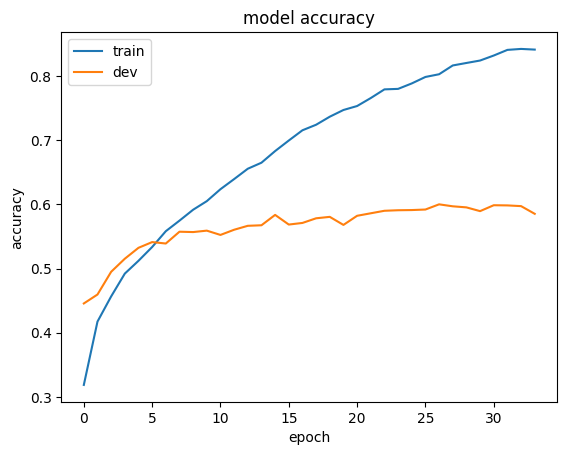

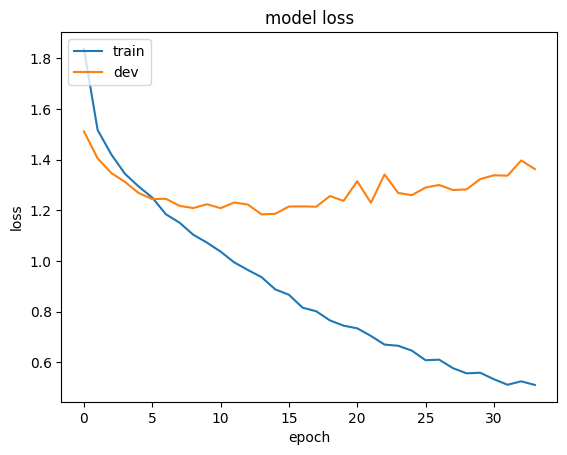

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

In [ ]:
epoch_str = '-EPOCHS_' + str(EPOCHS)
test_acc = 'test_acc_%.3f' % results_test[1]
model.save('/content/drive/My Drive/FeelBeat' + 'EfficientNetV2B1' + epoch_str + test_acc + '.h5')

In [ ]:
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button").click()
}setInterval(ClickConnect,600000)